In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import os
from collections import defaultdict
import numpy as np

In [2]:
def plotErr(x, y, std, xlabel, ylabel, outputFile):
    plt.matplotlib.rcParams.update({'font.size':40})
    fig1, (ax1) = plt.subplots(nrows = 1, ncols=1, figsize = (8, 6))
    ax1.errorbar(x, y, yerr=list(std), lw=3.0)
    ax1.set_xlabel(xlabel, fontsize=40)
    ax1.set_ylabel(ylabel, fontsize=40)
    #plt.savefig(os.getcwd() + outputFile, format = 'pdf', dpi=300, bbox_inches='tight')
    
# plot per barcode
def plotErrPerBarcode(df, outputFile):
    x = df.groupby('barcode_count_bfPCR')['barcode_count_bfPCR'].last()
    y = df.groupby('barcode_count_bfPCR')['barcode_count_afPCR'].mean()
    std = df.groupby('barcode_count_bfPCR')['barcode_count_afPCR'].std().fillna(0)
    plotErr(x, y, std, 'UMI count', 'Coverage ratio (after/before PCR)', outputFile)
    
def plotErrPerPayload(df, outputFile):
    s1 = df.groupby('payloadID')['barcode_seq'].count()
    s2 = df.groupby('payloadID')['barcode_count_afPCR'].sum()/s1
    new_df = pd.concat([s1, s2], axis=1)
    new_df = new_df.rename(columns={"barcode_seq": "barcode_count_bfPCR", 0: "barcode_count_afPCR"})
    x = new_df['barcode_count_bfPCR'].groupby(new_df['barcode_count_bfPCR']).last()
    y = new_df['barcode_count_afPCR'].groupby(new_df['barcode_count_bfPCR']).mean()
    std = new_df['barcode_count_afPCR'].groupby(new_df['barcode_count_bfPCR']).std().fillna(0)
    plotErr(x, y, std, 'UMI count', 'Amplification ratio', outputFile)
    return (x, std)

In [7]:
df = pd.read_csv('./data/data_UMI.csv', usecols = [0,1,2,3])
df.head(5)

,payloadID,barcode_count_afPCR,barcode_count_bfPCR,barcode_seq
0,2,8,1,GTTTT
1,3,4,2,GGAAC
2,3,20,2,CCATA
3,6,4,1,CTTAA
4,7,12,2,AAAGG


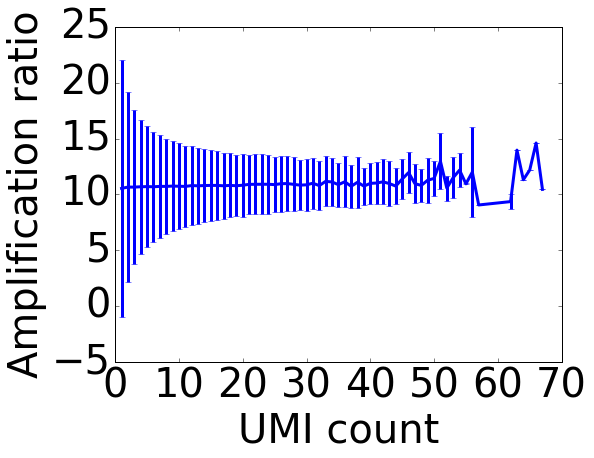

In [8]:
#df = pd.read_csv('./data/data_UMI.csv', usecols = [0, 1,2])
df2 = df[df['barcode_count_bfPCR'] >= 1]
(UMI_count, std) = plotErrPerPayload(df, 'fig_ratioVSCovBfPCR_perPayload.pdf')

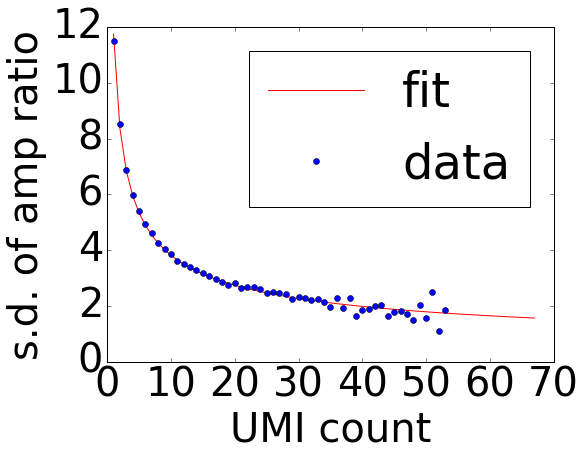

In [9]:
from scipy.optimize import curve_fit

def func(x, k, a):
    return k + a/np.sqrt(x)

xdata = np.array(UMI_count[:53])
ydata = np.array(std[:53])

popt, pcov = curve_fit(func, xdata, ydata)

plt.matplotlib.rcParams.update({'font.size':40})
fig1, (ax1) = plt.subplots(nrows = 1, ncols=1, figsize = (8, 6))
ax1.plot(UMI_count, func(UMI_count, *popt), "r-", label="fit")
ax1.plot(xdata, ydata, "o", label="data")
ax1.set_xlabel("UMI count", fontsize=40)
ax1.set_ylabel("s.d. of amp ratio", fontsize=40)
ax1.legend(loc="upper right", numpoints=1)
#plt.savefig("./fig/Fig_AmpRatio_Fit.pdf", dpi=300, bbox_inches="tight",fmt = "pdf")